# Assignment Week 3 - Group 5

### Cosimo Individual Work


In [1]:
import CambiCosimo_Functions as cc
#Some Functions to make this process easier and cleaner
import importlib
importlib.reload(cc)

<module 'CambiCosimo_Functions' from 'C:\\Users\\ccambi\\Desktop\\NEU\\EAI6000\\CambiCosimo_Functions.py'>

In [2]:
import pandas as pd
import numpy as np
import math as m
from datetime import date
import geopy.distance
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, ElasticNet, LogisticRegression

import time

#import seaborn as sns

In [3]:
filename1 = "fraudTrain.csv"
df_1 = pd.read_csv(filename1)
filename2 = "fraudTest.csv"
df_2 = pd.read_csv(filename2)

fraud_df_all = df_1.append(df_2)

#set to a sample of .1 to get all of the code working correctly, change to 1 for actuall run
#fraud_df = fraud_df_all.sample(frac=.01,
#                                random_state=12)
fraud_df=fraud_df_all

In [4]:
#Custom Functions From Craig:
def calculate_age(born):
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

def calculate_distance(row):
    coords_1 = (row['lat'], row['long'])
    coords_2 = (row['merch_lat'], row['merch_long'])
    return geopy.distance.geodesic(coords_1, coords_2).km

# Answer from https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
# The answers above are based on the Haversine formula, which assumes the earth is a sphere,
# which results in errors of up to about 0.5% (according to help(geopy.distance)). 
# Vincenty distance uses more accurate ellipsoidal models such as WGS-84, and is implemented in geopy. For example,
def calculate_distance2(row):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(row['lat'])
    lon1 = radians(row['long'])
    lat2 = radians(row['merch_lat'])
    lon2 = radians(row['merch_long'])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    print(distance)

In [5]:
# First derive columns
if 'trans_date_trans_time' in fraud_df.columns:
    fraud_df['txn_datetime'] =  pd.to_datetime(fraud_df['trans_date_trans_time'], format='%Y-%m-%d %H:%M:%S')

if 'dob' in fraud_df.columns:
    fraud_df['age'] = [calculate_age(d) for d in pd.to_datetime(fraud_df['dob'], format='%Y-%m-%d')]
    
if set(['lat', 'long', 'merch_lat', 'merch_long']).issubset(set(fraud_df.columns)):
     fraud_df['distance'] = [calculate_distance(row) for _, row in fraud_df.iterrows()]
        
fraud_df['hour'] = fraud_df['txn_datetime'].dt.hour
fraud_df['day'] = fraud_df['txn_datetime'].dt.day
fraud_df['month'] = fraud_df['txn_datetime'].dt.month
fraud_df['year'] = fraud_df['txn_datetime'].dt.year

#create a seasons category??
#create a time of day category??

fraud_df['log_amt'] = [m.log(n) for n in fraud_df['amt']] 

In [6]:
#(dataframe, max number of unique values to show)
cc.UniqueValues(fraud_df,30)

Unnamed: 0: 1296675 unique values
trans_date_trans_time: 1819551 unique values
cc_num: 999 unique values
merchant: 693 unique values
category
['misc_net' 'grocery_pos' 'entertainment' 'gas_transport' 'misc_pos'
 'grocery_net' 'shopping_net' 'shopping_pos' 'food_dining' 'personal_care'
 'health_fitness' 'travel' 'kids_pets' 'home']
amt: 60616 unique values
first: 355 unique values
last: 486 unique values
gender
['F' 'M']
street: 999 unique values
city: 906 unique values
state: 51 unique values
zip: 985 unique values
lat: 983 unique values
long: 983 unique values
city_pop: 891 unique values
job: 497 unique values
dob: 984 unique values
trans_num: 1852394 unique values
unix_time: 1819583 unique values
merch_lat: 1754157 unique values
merch_long: 1809753 unique values
is_fraud
[0 1]
txn_datetime: 1819551 unique values
age: 82 unique values
distance: 1852394 unique values
hour
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
day: 31 unique values
month
[ 1  2  3  4 

In [7]:
#create target lables
#target will be a binary classification variable for logistic regression: is_fraud
fraud_df['Target'] = fraud_df['is_fraud']

In [8]:
#Review the prevalence of the positive class for target
print('Prevalence of the positive class for Target: {:.3f}'.format(cc.calc_prevalence(fraud_df['Target'].values)))

Prevalence of the positive class for Target: 0.005


In [9]:
#create a list to hold our categorical columns and one to hold our numerical columns
cat_col = ['category','gender']
num_col = ['age','city_pop','distance','amt','month','hour','day','year']

In [10]:
#make sure there are no missing values 
print(fraud_df[cat_col].isnull().sum().sort_values(ascending = False).head(50))
print(fraud_df[num_col].isnull().sum().sort_values(ascending = False).head(50))

gender      0
category    0
dtype: int64
year        0
day         0
hour        0
month       0
amt         0
distance    0
city_pop    0
age         0
dtype: int64


In [11]:
#In order for categorical columns to work we have to one hot encode them
if len(cat_col)>0: 
    cat_onehotencode = pd.get_dummies(fraud_df[cat_col],drop_first = True)
    cat_col_onehotencode = list(cat_onehotencode.columns)
    fraud_df = pd.concat([fraud_df,cat_onehotencode], axis = 1)

else:
    cat_col_onehotencode = []

In [12]:
input_col = (num_col + cat_col_onehotencode)

In [ ]:
#check for colinearity and create a new input column list for the reduced set
input_col_reduced = cc.auto_vif(fraud_df[input_col],7)

In [17]:
print('Total number of features: {}'.format(len(num_col + cat_col_onehotencode)))
print('Numerical Features: {}'.format(len(num_col)))
print('Categorical Features: {}'.format(len(cat_col_onehotencode)))
#print('Total number of features after coliniarity reduction: {}'.format(len(input_col_reduced)))

Total number of features: 22
Numerical Features: 8
Categorical Features: 14


In [13]:
#build Training/Validation/Test Samples 
#(dataframe,randomseed,train split)
train_ub,valid,test = cc.Train_Valid_Test_Split(fraud_df[input_col +['Target']],12,.7)

In [23]:
#balance the data set via Smote
train = cc.balance_train_df(train_ub,'Sub','Target')

#Possible alternative is to underdampe the data
#train = cc.balance_train_df(train_ub,'Sub','Target')

Balance Method Selected is  Sub
Train balanced prevalence(n = 13,480):0.500


In [24]:
# create the X and y matrices for models
X_train = train[input_col].values
#X_train_rd = train[input_col_reduced].values
X_valid = valid[input_col].values
#X_valid_rd = valid[input_col_reduced].values
X_test = test[input_col].values

y_train = train['Target'].values
y_valid = valid['Target'].values
y_test = test['Target'].values

In [25]:
#This creates scalars in order to scale the data so each variable is of similar size.
#Use the unbalenced data set
scaler  = StandardScaler()
scaler.fit(train_ub[input_col].values)

#scaler_reduced  = StandardScaler()
#scaler_reduced.fit(train_ub[input_col_reduced].values)

# transform our data matrices - this applies our scalar and scales the matrices for training and validation data
X_train_tf = scaler.transform(X_train)
#X_train_rd_tf = scaler_reduced.transform(X_train_rd)
X_valid_tf = scaler.transform(X_valid)
#X_valid_rd_tf = scaler_reduced.transform(X_valid_rd)
X_test_tf = scaler.transform(X_test)

# Start Modeling

In [26]:
#Scoring used for cross validation
auc_scoring = make_scorer(roc_auc_score)

# Logistic Regression

In [ ]:
#Create a Baseline Model
lr=LogisticRegression(random_state = 12)

lr.fit(X_train_rd, y_train)

y_train_preds = lr.predict_proba(X_train_rd_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_rd_tf)[:,1]

print('Baseline Logistic Regression')
lr_train_base_auc = roc_auc_score(y_train, y_train_preds)
lr_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(lr_train_base_auc))
print('Validation AUC:{:.3f}'.format(lr_valid_base_auc))

In [ ]:
#help(LogisticRegression)
#lr.get_params()

In [ ]:
#Create grid Optimized Model

C = [0.002,0.02,1.2,2,20]
class_weight = [None]
dual = [False,True]
fit_intercept = [False,True]
intercept_scaling = [1]
l1_ratio = [None]
max_iter = [50,100,250]
multi_class = ['auto']
n_jobs = [-1]
random_state = [12]
penalty = ['l1', 'l2', 'elasticnet']
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
tol = [0.001,0.0001,0.00001]
verbose = [1]
warm_start = [False,True]

#param_grid

param_grid_lr = {'C': C,
 'class_weight': class_weight,
 'dual': dual,
 'fit_intercept': fit_intercept,
 'intercept_scaling': intercept_scaling,
 'l1_ratio': l1_ratio,
 'max_iter': max_iter,
 'multi_class': multi_class,
 'n_jobs': n_jobs,
 'penalty': penalty,
 'random_state': random_state,
 'solver': solver,
 'tol': tol,
 'verbose': verbose,
 'warm_start': warm_start}

print(param_grid_lr)


In [ ]:
# create the cross-validation by grid method
lr_grid = GridSearchCV(estimator = lr, param_grid = param_grid_lr, 
                            cv = 5, scoring=auc_scoring,verbose = 3, n_jobs = -1, 
                            error_score=0)


# fit the random search model (this will take a few minutes)
t1 = time.time()
lr_grid.fit(X_train_rd_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',lr_grid.best_params_)

In [ ]:
print('Optimized Logistic Regression')
y_train_preds_grid = lr_grid.best_estimator_.predict_proba(X_train_rd_tf)[:,1]
y_valid_preds_grid = lr_grid.best_estimator_.predict_proba(X_valid_rd_tf)[:,1]

lr_train_opt_auc = roc_auc_score(y_train, y_train_preds_grid)
lr_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_grid)

print('Training AUC:{:.3f}'.format(lr_train_opt_auc))
print('Validation AUC:{:.3f}'.format(lr_valid_opt_auc))

## Decision Tree

In [32]:
#Create a Baseline Model
dt=DecisionTreeClassifier(random_state = 12)

dt.fit(X_train, y_train)

y_train_preds = dt.predict_proba(X_train_tf)[:,1]
y_valid_preds = dt.predict_proba(X_valid_tf)[:,1]

print('Baseline Decision Tree')
dt_train_base_auc = roc_auc_score(y_train, y_train_preds)
dt_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(dt_train_base_auc))
print('Validation AUC:{:.3f}'.format(dt_valid_base_auc))


Baseline Decision Tree
Training AUC:0.482
Validation AUC:0.479


In [ ]:
#help(DecisionTreeClassifier)
#dt_sub.get_params()

In [ ]:
#Create Optimized Model

ccp_alpha=[0.0,0.2]
class_weight=[None]
criterion=['gini','entropy']
max_depth=[None]
max_features=["auto", "sqrt", "log2","none"]
max_leaf_nodes=[None]
min_impurity_decrease=[0.0]
min_impurity_split=[None]
min_samples_leaf=[1,2,10]
min_samples_split=[1,2,10]
min_weight_fraction_leaf=[0.0,0.1,0.25]
random_state=[12]
splitter=['best','random']

#param_grid

param_grid_dt = {'ccp_alpha': ccp_alpha,
 'class_weight': class_weight,
 'criterion': criterion,
 'max_depth': max_depth,
 'max_features': max_features,
 'max_leaf_nodes': max_leaf_nodes,
 'min_impurity_decrease': min_impurity_decrease,
 'min_impurity_split': min_impurity_split,
 'min_samples_leaf': min_samples_leaf,
 'min_samples_split': min_samples_split,
 'min_weight_fraction_leaf': min_weight_fraction_leaf,
 'random_state': random_state,
 'splitter': splitter}

print(param_grid_dt)

In [ ]:
# create the cross-validation by grid method
dt_grid = GridSearchCV(estimator = dt, param_grid = param_grid_dt, 
                            cv = 5, scoring=auc_scoring,verbose = 1, n_jobs = -1, 
                            error_score=0)

# fit the random search model (this will take a few minutes)
t1 = time.time()
dt_grid.fit(X_train_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',dt_grid.best_params_)

In [ ]:
print('Optimized Decision Tree')
y_train_preds_grid = dt_grid.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_grid = dt_grid.best_estimator_.predict_proba(X_valid_tf)[:,1]

dt_train_opt_auc = roc_auc_score(y_train, y_train_preds_grid)
dt_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_grid)

print('Training AUC:{:.3f}'.format(dt_train_opt_auc))
print('Validation AUC:{:.3f}'.format(dt_valid_opt_auc))

## Random Forest

In [31]:
#Create a Baseline Model
rf=RandomForestClassifier(random_state = 12)

rf.fit(X_train, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Baseline Random Forest')
rf_train_base_auc = roc_auc_score(y_train, y_train_preds)
rf_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(rf_train_base_auc))
print('Validation AUC:{:.3f}'.format(rf_valid_base_auc))

Baseline Random Forest
Training AUC:0.380
Validation AUC:0.371


In [ ]:
#help(RandomForestClassifier)
#rf_sub.get_params()

In [ ]:
#Create Optimized Model

bootstrap=[True,False]
ccp_alpha=[0.0,0.2]
class_weight=[None]
criterion=['gini','entropy']
max_depth=[None]
max_features=["auto", "sqrt", "log2","none"]
max_leaf_nodes=[None]
max_samples=[0,.5,1]
min_impurity_decrease=[0.0]
min_impurity_split=[None]
min_samples_leaf=[1,2,10]
min_samples_split=[1,2,10]
n_estimators=[10,100,250]#,1000]
n_jobs=[-1]
oob_score=[True,False]
random_state=[12]
verbose=[1]
warm_start=[True,False]

#param_grid

param_grid_rf = {'bootstrap': bootstrap,
 'ccp_alpha': ccp_alpha,
 'class_weight': class_weight,
 'criterion': criterion,
 'max_depth': max_depth,
 'max_features': max_features,
 'max_leaf_nodes': max_leaf_nodes,
 'max_samples': max_samples,
 'min_impurity_decrease': min_impurity_decrease,
 'min_impurity_split': min_impurity_split,
 'min_samples_leaf': min_samples_leaf,
 'min_samples_split': min_samples_split,
 'min_weight_fraction_leaf': min_weight_fraction_leaf,
 'n_estimators': n_estimators,
 'n_jobs': n_jobs,
 'oob_score': oob_score,
 'random_state': random_state,
 'verbose': verbose,
 'warm_start': warm_start}

print(param_grid_rf)

In [ ]:

# create the cross-validation by grid method
#rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid_rf, 
#                            cv = 2, scoring=auc_scoring,verbose = 1, n_jobs = -1, #changed cv to 2 due to time
#                            error_score=0)

#Random grid search used for time constraints:

rf_rand = RandomizedSearchCV(estimator = rf, param_distributions = param_grid_rf, 
                            n_iter = 1000, cv = 5, scoring=auc_scoring,verbose = 1, n_jobs = -1,
                            error_score=0, random_state=12)
        

# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_rand.fit(X_train_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',rf_rand.best_params_)

In [ ]:
print('Optimized Random Forest')
y_train_preds_rand = rf_rand.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_rand = rf_rand.best_estimator_.predict_proba(X_valid_tf)[:,1]

rf_train_opt_auc = roc_auc_score(y_train, y_train_preds_rand)
rf_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_rand)

print('Training AUC:{:.3f}'.format(rf_train_opt_auc))
print('Validation AUC:{:.3f}'.format(rf_valid_opt_auc))

## Gradient Boosting Classifier

In [27]:
#Create a Baseline Model
gbc=GradientBoostingClassifier(random_state = 12)

gbc.fit(X_train, y_train)

y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Baseline Gradient Boosting Classifier')
gbc_train_base_auc = roc_auc_score(y_train, y_train_preds)
gbc_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training AUC:{:.3f}'.format(gbc_train_base_auc))
print('Validation AUC:{:.3f}'.format(gbc_valid_base_auc))

Baseline Gradient Boosting Classifier
Training AUC:0.466
Validation AUC:0.467


## Learning Curves to help with hypertuning parameters

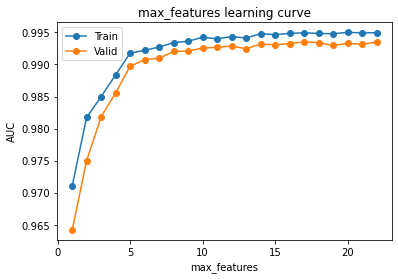

In [28]:
#learning curves
max_features = np.arange(1,23,1)

train_aucs = np.zeros(len(max_features))
valid_aucs = np.zeros(len(max_features))

for jj in range(len(max_features)):
    max_feature = max_features[jj]
    # fit model
    gbc =GradientBoostingClassifier(max_features=max_feature, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(max_features, train_aucs,'o-',label = 'Train')
plt.plot(max_features, valid_aucs,'o-',label = 'Valid')

plt.xlabel('max_features')
plt.title('max_features learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

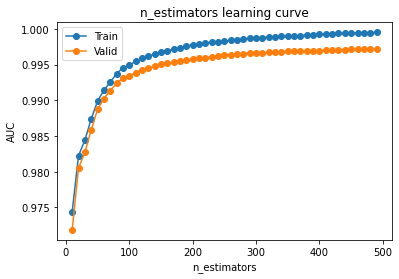

In [29]:
#learning curves
n_estimators = np.arange(10,500,10)

train_aucs = np.zeros(len(n_estimators))
valid_aucs = np.zeros(len(n_estimators))

for jj in range(len(n_estimators)):
    n_estimator = n_estimators[jj]
    print
    # fit model
    gbc =GradientBoostingClassifier(n_estimators=n_estimator, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(n_estimators, train_aucs,'o-',label = 'Train')
plt.plot(n_estimators, valid_aucs,'o-',label = 'Valid')

plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.title('n_estimators learning curve')
plt.legend()
plt.show()

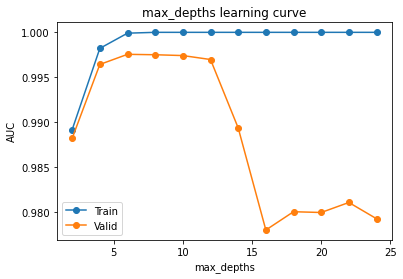

In [36]:
#learning curves
max_depths = np.arange(2,26,2)

train_aucs = np.zeros(len(max_depths))
valid_aucs = np.zeros(len(max_depths))

for jj in range(len(max_depths)):
    max_depth = max_depths[jj]
    # fit model
    gbc =GradientBoostingClassifier(max_depth=max_depth, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(max_depths, train_aucs,'o-',label = 'Train')
plt.plot(max_depths, valid_aucs,'o-',label = 'Valid')

plt.xlabel('max_depths')
plt.title('max_depths learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

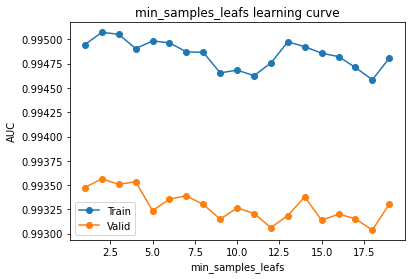

In [34]:
#learning curves
min_samples_leafs = np.arange(1,20,1)

train_aucs = np.zeros(len(min_samples_leafs))
valid_aucs = np.zeros(len(min_samples_leafs))

for jj in range(len(min_samples_leafs)):
    min_samples_leaf = min_samples_leafs[jj]
    # fit model
    gbc =GradientBoostingClassifier(min_samples_leaf=min_samples_leaf, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(min_samples_leafs, train_aucs,'o-',label = 'Train')
plt.plot(min_samples_leafs, valid_aucs,'o-',label = 'Valid')

plt.xlabel('min_samples_leafs')
plt.title('min_samples_leafs learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

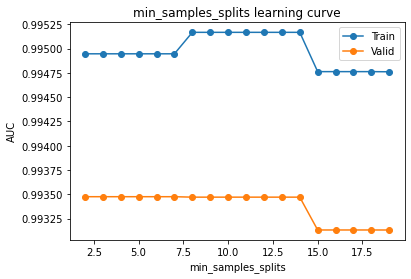

In [35]:
#learning curves
min_samples_splits = np.arange(2,20,1)

train_aucs = np.zeros(len(min_samples_splits))
valid_aucs = np.zeros(len(min_samples_splits))

for jj in range(len(min_samples_splits)):
    min_samples_split = min_samples_splits[jj]
    # fit model
    gbc =GradientBoostingClassifier(min_samples_split=min_samples_split, random_state=12)
    gbc.fit(X_train_tf, y_train)
    
    # get predictions
    y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
    y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

plt.plot(min_samples_splits, train_aucs,'o-',label = 'Train')
plt.plot(min_samples_splits, valid_aucs,'o-',label = 'Valid')

plt.xlabel('min_samples_splits')
plt.title('min_samples_splits learning curve')
plt.ylabel('AUC')
plt.legend()
plt.show()

## Grid Search

In [37]:
#Create Optimized Model

ccp_alpha= [0.0,0,5,1]
criterion = ['friedman_mse','mse','mae']
init= ['zero']
learning_rate = [0.01,0.05,0.1,0.25]
loss = ['deviance', 'exponential']
max_depth = [4,6,8,10,12]
max_features = ['auto','log2',8]
max_leaf_nodes = [10,None]
min_impurity_decrease = [0.0]
min_impurity_split = [None]
min_samples_leaf = [1,2,3,4]
min_samples_split = [2]
min_weight_fraction_leaf = [0.0]
n_estimators = range(150,501,50)
n_iter_no_change = [None]
random_state = [12]
subsample = [0.75,1.0]
tol = [0.0001,0.001,0.01]
validation_fraction = [0.1,0.25]
verbose = [1]
warm_start = [True,False]
    
# param grid
param_grid_gbc = {'ccp_alpha' : ccp_alpha,
                    'criterion': criterion,
                    'init': init,
                    'learning_rate': learning_rate,
                    'loss': loss,
                    'max_depth': max_depth,
                    'max_features': max_features,
                    'max_leaf_nodes': max_leaf_nodes,
                    'min_impurity_decrease': min_impurity_decrease,
                    'min_impurity_split': min_impurity_split,
                    'min_samples_leaf': min_samples_leaf,
                    'min_samples_split': min_samples_split,
                    'n_estimators': n_estimators,
                    'n_iter_no_change': n_iter_no_change,
                    'random_state': random_state,
                    'subsample': subsample,
                    'tol': tol,
                    'validation_fraction': validation_fraction,
                    'verbose': verbose,
                    'warm_start': warm_start
                    }

print(param_grid_gbc)

{'ccp_alpha': [0.0, 0, 5, 1], 'criterion': ['friedman_mse', 'mse', 'mae'], 'init': ['zero'], 'learning_rate': [0.01, 0.05, 0.1, 0.25], 'loss': ['deviance', 'exponential'], 'max_depth': [4, 6, 8, 10, 12], 'max_features': ['auto', 'log2', 8], 'max_leaf_nodes': [10, None], 'min_impurity_decrease': [0.0], 'min_impurity_split': [None], 'min_samples_leaf': [1, 2, 3, 4], 'min_samples_split': [2], 'n_estimators': range(150, 501, 50), 'n_iter_no_change': [None], 'random_state': [12], 'subsample': [0.75, 1.0], 'tol': [0.0001, 0.001, 0.01], 'validation_fraction': [0.1, 0.25], 'verbose': [1], 'warm_start': [True, False]}


In [ ]:
# create the cross-validation by grid method
#gbc_grid = GridSearchCV(estimator = gbc, param_grid = param_grid_gbc, 
#                            cv = 2, scoring=auc_scoring,verbose = 1, n_jobs = -1, #changed cv to 2 due to time
#                            error_score=0)

#Random grid search used for time constraints:

gbc_rand = RandomizedSearchCV(estimator = gbc, param_distributions = param_grid_gbc, 
                            n_iter = 500, cv = 2, scoring=auc_scoring,verbose = 1, n_jobs = -1,
                            error_score=0, random_state=12)
        

# fit the random search model (this will take a few minutes)
t1 = time.time()
gbc_rand.fit(X_train_tf, y_train)
t2 = time.time()
print('Elapsed Time:',(t2-t1))

print('Best Parameters:',gbc_rand.best_params_)

Fitting 2 folds for each of 500 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 24.1min


In [ ]:
print('Optimized Gradient Boosting Classifier')
y_train_preds_rand = gbc_rand.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_rand = gbc_rand.best_estimator_.predict_proba(X_valid_tf)[:,1]

gbc_train_opt_auc = roc_auc_score(y_train, y_train_preds_rand)
gbc_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_rand)

print('Training AUC:{:.3f}'.format(gbc_train_opt_auc))
print('Validation AUC:{:.3f}'.format(gbc_valid_opt_auc))

In [ ]:
thresh = 0.5

y_train_preds_gbc = gbc_rand.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_gbc = gbc_rand.best_estimator_.predict_proba(X_valid_tf)[:,1]
y_test_preds_gbc = gbc_rand.best_estimator_.predict_proba(X_test_tf)[:,1]

print('GBC Training:')
train_auc, train_accuracy, train_recall, train_precision, train_specificity = cc.print_report(y_train,y_train_preds_gbc, thresh)
print('GBC Validation:')
valid_auc, valid_accuracy, valid_recall, valid_precision, valid_specificity = cc.print_report(y_valid,y_valid_preds_gbc, thresh)
print('GBC Test:')
test_auc, test_accuracy, test_recall, test_precision, test_specificity = cc.print_report(y_test,y_test_preds_gbc, thresh)
